In [1]:
import pandas as pd
from glob import glob
from matplotlib import pyplot as plt

In [2]:
dataset_names = ['LiGen', 'Query26', 'Stereomatch']

In [3]:
files = list(glob('./../../MALIBOO/df_results_new/*.json')) + list(glob('./../results/simplified_runs/*.json'))
sorted(files)

['./../../MALIBOO/df_results_new/2023-09-24_1729_LiGen_mq0.json',
 './../../MALIBOO/df_results_new/2023-09-24_1729_LiGen_mq5.json',
 './../../MALIBOO/df_results_new/2023-09-24_1729_Query26_mq0.json',
 './../../MALIBOO/df_results_new/2023-09-24_1729_Stereomatch_mq0.json',
 './../../MALIBOO/df_results_new/2023-09-24_1729_Stereomatch_mq5.json',
 './../../MALIBOO/df_results_new/2023-09-24_2153_LiGen_mq0.json',
 './../../MALIBOO/df_results_new/2023-09-24_2153_LiGen_mq5.json',
 './../../MALIBOO/df_results_new/2023-09-24_2153_Query26_mq0.json',
 './../../MALIBOO/df_results_new/2023-09-24_2153_Stereomatch_mq0.json',
 './../../MALIBOO/df_results_new/2023-09-24_2153_Stereomatch_mq5.json',
 './../../MALIBOO/df_results_new/2023-09-24_2312_LiGen_mq0.json',
 './../../MALIBOO/df_results_new/2023-09-24_2312_LiGen_mq5.json',
 './../../MALIBOO/df_results_new/2023-09-24_2312_Query26_mq0.json',
 './../../MALIBOO/df_results_new/2023-09-24_2312_Stereomatch_mq0.json',
 './../../MALIBOO/df_results_new/2023-09

In [4]:
dfs = {}
for filename in files:
    df = pd.read_json(filename, orient='records')
    # df = df.set_index('iteration')
    if 'simplified_runs' in filename:
        df['algorithm'] = 'q-KG'
    else:
        df['algorithm'] = 'MALIBOO'
    df['filename'] = filename.rsplit('/', 1)[-1].replace('.json', '')
    for dataset_name in dataset_names:
        if dataset_name.upper() in filename.upper():
            dfs.setdefault(dataset_name.lower(), []).append(df)
            break

In [5]:
def select_data(dfs, selected_dataset):
    selected_dfs = {}
    for df in dfs[selected_dataset.lower()]:
        if len(df) == 1:
            # print(df.iloc[0])
            continue
        min_cost = df['computed_cost'].min()
        best_row = df.sort_values(['computed_cost', 'n_evaluations']).iloc[0]
        # print(best_row)
        algo = best_row['algorithm']
        if algo == 'q-KG':
            q = best_row['q']
            key = f'{algo}'.replace('q', str(q))
        else:
            mq = best_row['filename'][-1]
            key = f'EI mq{mq}'
        data_dict = {'data': df, 'computed_cost': best_row['computed_cost'], 'n_evaluations': best_row['n_evaluations']}
        selected_dfs.setdefault(key, data_dict)
        if (selected_dfs[key]['computed_cost'] > best_row['computed_cost'] 
            or (selected_dfs[key]['computed_cost'] == best_row['computed_cost'] and selected_dfs[key]['n_evaluations'] >= best_row['n_evaluations'])):
            print('Better!', key)
            print(min_cost)
            selected_dfs[key] = data_dict
    return selected_dfs

In [6]:
df

,iteration,n_initial_points,q,m,target,suggested_minimum,known_minimum,closest_point_in_domain,computed_cost,n_evaluations,error,error_ratio,algorithm,filename
0,0,7,7,12,Query26,"[5.190683912602241, 3.990386279741641]","[3.0, 9.0]","[5.0, 4.0]",1300415,14,616733,0.902076,q-KG,Query26_2023-09-06_1758


In [7]:
result_list = []
for dataset_name in dataset_names:
    selected_dfs = select_data(dfs, dataset_name)
    known_minimum = None    
    for key, info in selected_dfs.items():
        df = info['data']
        last_row = df.iloc[-1]
        if known_minimum is None:
            known_minimum = info['computed_cost'] - last_row['error']
            result_list.append({
                'Dataset': dataset_name,
                'Algorithm': 'Known Minimum',
                '# Evaluations': '-',
                'Cost': known_minimum,
                'Error': 0,
                'Error Ratio': 0
        })
        result_list.append({
            'Dataset': dataset_name,
            'Algorithm': key,
            '# Evaluations': info['n_evaluations'],
            'Cost': info['computed_cost'],
            'Error': last_row['error'],
            'Error Ratio': last_row['error'] / known_minimum
        })
    
    # result_df = pd.DataFrame([{'Algorithm': key, '# Evaluations': ,'Cost': df['computed_cost']}
    #                           ])
result_df = pd.DataFrame(result_list)

Better! EI mq5
876.700248796
Better! EI mq0
675.155498504
Better! EI mq5
781.14224583
Better! EI mq5
766.677296
Better! 5-KG
781.14224583
Better! 5-KG
721.631752192
Better! 8-KG
867.220858377
Better! 7-KG
826.223434
Better! 7-KG
826.223434
Better! 8-KG
826.223434
Better! 3-KG
1091.129174631
Better! EI mq0
691836
Better! EI mq0
691836
Better! 3-KG
1237512.4
Better! 7-KG
1247080
Better! 3-KG
683682
Better! 4-KG
1294435
Better! 5-KG
1228016
Better! 4-KG
711864
Better! 4-KG
683682
Better! 7-KG
1206189
Better! EI mq5
36791
Better! EI mq0
36791
Better! 4-KG
37785
Better! 5-KG
38078
Better! 3-KG
54662
Better! 10-KG
36900
Better! 4-KG
36900
Better! 3-KG
40638


In [8]:
mask = result_df['Dataset'] == 'Query26'
result_df[mask][['Algorithm', '# Evaluations', 'Cost', 'Error', 'Error Ratio']]
result_df.loc[9, 'Cost'] = 683682.0
result_df[mask][['Algorithm', '# Evaluations', 'Cost', 'Error', 'Error Ratio']]

,Algorithm,# Evaluations,Cost,Error,Error Ratio
7,Known Minimum,-,683682.0,0.0,0.000000
8,EI mq0,10,691836.0,8154.0,0.011927
9,3-KG,15,683682.0,0.0,0.000000
10,7-KG,28,1206189.0,588463.0,0.860726
11,4-KG,39,683682.0,0.0,0.000000
12,5-KG,15,1228016.0,931488.0,1.362458


In [9]:
mask = result_df['Dataset'] == 'Stereomatch'
result_df[mask][['Algorithm', '# Evaluations', 'Cost', 'Error', 'Error Ratio']]

,Algorithm,# Evaluations,Cost,Error,Error Ratio
13,Known Minimum,-,36791.0,0.0,0.000000
14,EI mq5,10,36791.0,0.0,0.000000
15,EI mq0,10,36791.0,0.0,0.000000
16,4-KG,40,36900.0,109.0,0.002963
17,5-KG,70,38078.0,1287.0,0.034981
18,3-KG,37,40638.0,3847.0,0.104564
19,10-KG,180,36900.0,1343.0,0.036503


In [10]:
mask = result_df['Dataset'] == 'LiGen'
result_df[mask][['Algorithm', '# Evaluations', 'Cost', 'Error', 'Error Ratio']]

,Algorithm,# Evaluations,Cost,Error,Error Ratio
0,Known Minimum,-,667.544416,0.000000,0.000000
1,EI mq5,10,766.677296,99.132880,0.148504
2,EI mq0,64,675.155499,7.611083,0.011402
3,5-KG,70,721.631752,54.087336,0.081024
4,8-KG,16,826.223434,158.679018,0.237706
5,7-KG,14,826.223434,158.679018,0.237706
6,3-KG,39,1091.129175,423.584759,0.634542


In [11]:
selected_dfs['EI mq0'].keys()

dict_keys(['data', 'computed_cost', 'n_evaluations'])

In [12]:
def plot(selected_dfs, selected_dataset):
    plt.figure(figsize=(12, 5))
    for key, data_dict in selected_dfs.items():
        df = data_dict['data']
        if len(df) == 1:
            print(df.iloc[0])

        plt.plot(df['n_evaluations'], df['computed_cost'], 
                 label=key, 
                 marker='+', 
                 linestyle=':'
                )
    plt.legend()
    plt.xlabel('# evaluations')
    plt.ylabel('cost')
    plt.title(f'{selected_dataset}: Cost Comparison')

Better! EI mq5
876.700248796
Better! EI mq0
675.155498504
Better! EI mq5
781.14224583
Better! EI mq5
766.677296
Better! 5-KG
781.14224583
Better! 5-KG
721.631752192
Better! 8-KG
867.220858377
Better! 7-KG
826.223434
Better! 7-KG
826.223434
Better! 8-KG
826.223434
Better! 3-KG
1091.129174631


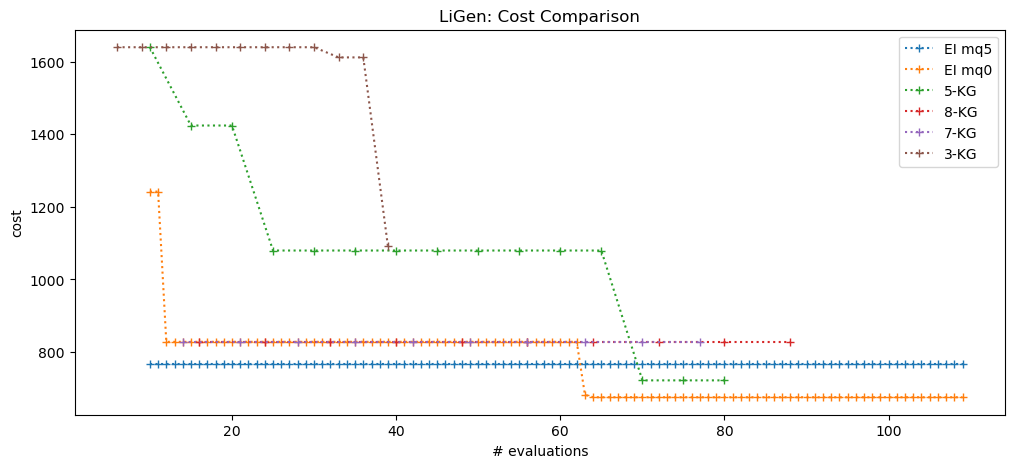

In [13]:
selected_dfs = select_data(dfs, 'LiGen')
plot(selected_dfs, 'LiGen')

Better! EI mq0
691836
Better! EI mq0
691836
Better! 3-KG
1237512.4
Better! 7-KG
1247080
Better! 3-KG
683682
Better! 4-KG
1294435
Better! 5-KG
1228016
Better! 4-KG
711864
Better! 4-KG
683682
Better! 7-KG
1206189


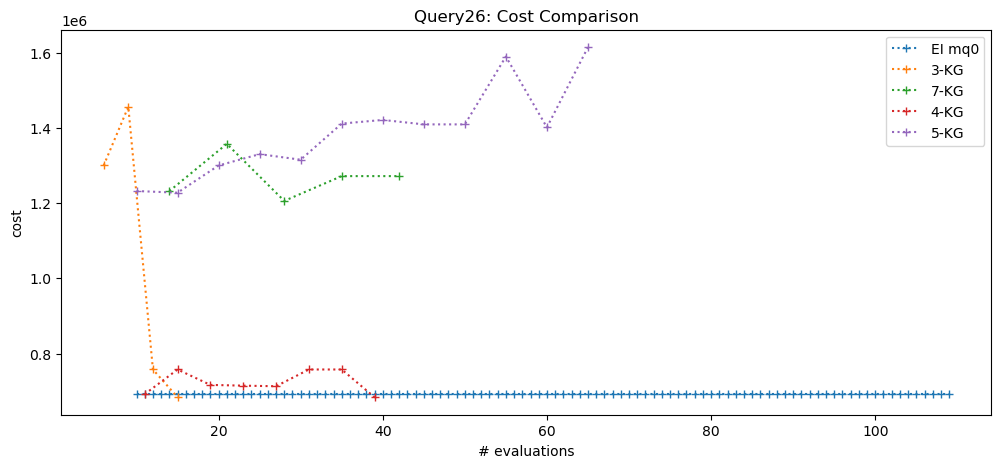

In [14]:
selected_dfs = select_data(dfs, 'Query26')
plot(selected_dfs, 'Query26')

Better! EI mq5
36791
Better! EI mq0
36791
Better! 4-KG
37785
Better! 5-KG
38078
Better! 3-KG
54662
Better! 10-KG
36900
Better! 4-KG
36900
Better! 3-KG
40638


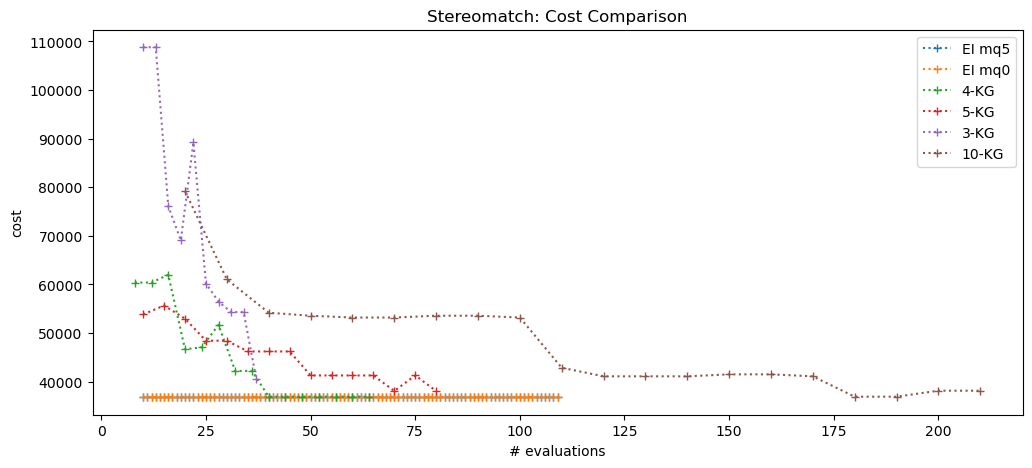

In [15]:
selected_dfs = select_data(dfs, 'Stereomatch')
plot(selected_dfs, 'Stereomatch')